In [ ]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AAPL.csv to AAPL (3).csv


In [ ]:
dataset = pd.read_csv('AAPL.csv')
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-01,1.502857,1.560714,1.500000,1.550714,1.034021,90384000
1,2009-12-02,1.542857,1.564286,1.529286,1.538571,1.025924,51324000
2,2009-12-03,1.538571,1.560000,1.497143,1.502143,1.001633,47824000
3,2009-12-04,1.495714,1.512143,1.483571,1.510714,1.007349,44485000
4,2009-12-05,1.492857,1.510714,1.480714,1.489286,0.993060,46544400


In [ ]:
dataset.info()
dataset.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3853 entries, 0 to 3852
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3853 non-null   object 
 1   Open       3853 non-null   float64
 2   High       3853 non-null   float64
 3   Low        3853 non-null   float64
 4   Close      3853 non-null   float64
 5   Adj Close  3853 non-null   float64
 6   Volume     3853 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 210.8+ KB


(3853, 7)

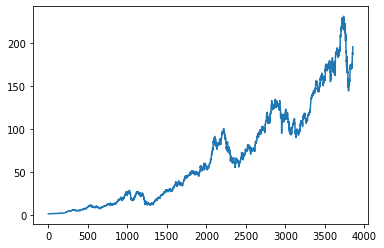

In [ ]:
plt.plot(dataset["Open"])
plt.show()

Predict the opening stock price of the data based on the opening stock prices for the past 60 days. So we need to only focus on the "Open" column.

In [ ]:
dataset2=dataset['Open']
dataset2.head()

0    1.502857
1    1.542857
2    1.538571
3    1.495714
4    1.492857
Name: Open, dtype: float64

In [ ]:
dataset2=pd.DataFrame(dataset2)
dataset2.shape

(3853, 1)

Here, we do feature scaling (standard scaling) to speed up the training.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset2 = scaler.fit_transform(dataset2)
dataset2[:10,:]

array([[0.00043285],
       [0.00060724],
       [0.00058855],
       [0.00040171],
       [0.00038926],
       [0.00035189],
       [0.00047334],
       [0.00024912],
       [0.00018685],
       [0.00052004]])

Here, we separate the train and test sets. We keep 30% of the dataset for tesing purposes.

In [ ]:
train_size = int(len(dataset2) * 0.7)
test_size = len(dataset2) - train_size
train, test = dataset2[0:train_size,:], dataset2[train_size:len(dataset2),:]
print(len(train), len(test))

2697 1156


Given the current time (t) we want to predict the opening stock price at the next time in the sequence (t+1), we can use the current time (t), as well as the 59 prior times (t-1, t-2, till t-59) as input variables.

So the problem in hand is the regression problem, the input variables are t-59, ..., t-1, t and the output variable is t+1.

In [ ]:
lag=60
for i in range(60):
  trainT=train[i:-lag+i,:]
  testT=test[i:-lag+i,:]
  if i==0: 
    trainX=trainT
    testX=testT
  else:
    trainX=np.hstack((trainX,trainT))
    testX=np.hstack((testX,testT))
    
trainY=train[lag:,:]    
testY=test[lag:,:]

In [ ]:
np.shape(trainX)

(2637, 60)

In [ ]:
np.shape(trainY)

(2637, 1)

Here, we need to reshape both the train set and the test set to be compatibe with LSTM layer in Keras: (batch, timestep, features)

In [ ]:
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1],1))
testX = testX.reshape((testX.shape[0], testX.shape[1],1)) 

In [ ]:
np.shape(trainX)

(2637, 60, 1)

Data is now ready to be used as input (X) to the LSTM with an input_shape of (second, third).

Now, we build our model: Add 2 LSTM layers and a dense layer as the last layer of the model

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(np.shape(trainX[1,:])), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_18 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


Train the model and elaborare /apply hyper-parameter optimization


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY[:,0], epochs=100, batch_size=1, verbose=2)

Epoch 1/100
2637/2637 - 53s - loss: 0.0011
Epoch 2/100
2637/2637 - 51s - loss: 8.0890e-04
Epoch 3/100
2637/2637 - 51s - loss: 7.7481e-04
Epoch 4/100
2637/2637 - 51s - loss: 7.4250e-04
Epoch 5/100
2637/2637 - 51s - loss: 6.3192e-04
Epoch 6/100
2637/2637 - 51s - loss: 6.8521e-04
Epoch 7/100
2637/2637 - 51s - loss: 6.3568e-04
Epoch 8/100
2637/2637 - 51s - loss: 6.3365e-04
Epoch 9/100
2637/2637 - 51s - loss: 6.4713e-04
Epoch 10/100
2637/2637 - 52s - loss: 6.0803e-04
Epoch 11/100
2637/2637 - 51s - loss: 5.8228e-04
Epoch 12/100
2637/2637 - 51s - loss: 6.2707e-04
Epoch 13/100
2637/2637 - 51s - loss: 6.0280e-04
Epoch 14/100
2637/2637 - 51s - loss: 6.1471e-04
Epoch 15/100
2637/2637 - 51s - loss: 5.5757e-04
Epoch 16/100
2637/2637 - 51s - loss: 5.4927e-04
Epoch 17/100
2637/2637 - 51s - loss: 5.2974e-04
Epoch 18/100
2637/2637 - 51s - loss: 5.6874e-04
Epoch 19/100
2637/2637 - 51s - loss: 5.4308e-04
Epoch 20/100
2637/2637 - 51s - loss: 5.6800e-04
Epoch 21/100
2637/2637 - 51s - loss: 5.4517e-04
Epoch

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [ ]:
np.shape(trainPredict)

(2637, 1)

In [ ]:
np.shape(trainY)

(2637, 1)

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.15 RMSE
Test Score: 9.94 RMSE


In [ ]:
np.shape(dataset2)

(3853, 1)

In [ ]:
np.shape(testPredict)

(1096, 1)

In [ ]:
np.shape(trainPredict)

(2637, 1)

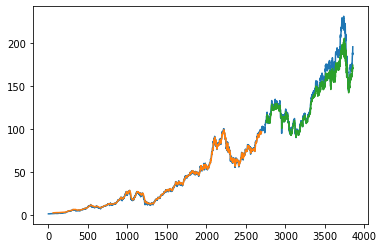

In [ ]:
# shift test predictions for plotting
trainPredictPlot = np.empty_like(dataset2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
testPredictPlot = np.empty_like(dataset2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lag*2):len(dataset2), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()